In [1]:
%matplotlib inline

In [47]:
from __future__ import print_function, division
import os, sys
import numpy as np, scipy as sp, pandas as pd
import scipy.io
import scipy.signal as signal, scipy.fftpack as ftpk, scipy.integrate as integrate, scipy.interpolate as interpolate
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
import tflearn
from sklearn import linear_model as lm, neural_network as nn
import sklearn.preprocessing as preproc
import sklearn.model_selection as modselect

original_dir = os.getcwd()

In [4]:
PLOT=True

In [5]:
e = np.exp(1)
pi = np.pi
pii = np.pi*1j
twopi = np.pi * 2
SR=400

In [6]:
import pywt
# import pyhht

In [7]:
from imp import reload
import glob

In [9]:
os.chdir('/home/mike/ve/ml')
# os.chdir('/home/mike/venvs/ml/ml/py')
print(os.getcwd())
from eegkaggle.vectorizers import naive, spectral
from eegkaggle.dio import dataio
from eegkaggle.plotting import plotstuff
from eegkaggle.msignal import wavelets, metrics, msig, auxfilter

/home/mike/ve/ml


In [10]:
reload(plotstuff)
reload(dataio)

<module 'eegkaggle.dio.dataio' from 'eegkaggle/dio/dataio.pyc'>

In [11]:
matplotlib.style.use('ggplot')

In [12]:
ssmall,smed, slarge, slong = (4,3), (8,6), (16,12), (16,4)
matplotlib.rcParams['figure.figsize'] = smed

Functions

In [57]:
def balanced_subsample(x,y,subsample_size=1.0):

    class_xs = []
    min_elems = None

    for yi in np.unique(y):
        elems = x[(y == yi)]
        class_xs.append((yi, elems))
        if min_elems == None or elems.shape[0] < min_elems:
            min_elems = elems.shape[0]

    use_elems = min_elems
    if subsample_size < 1:
        use_elems = int(min_elems*subsample_size)

    xs = []
    ys = []

    for ci,this_xs in class_xs:
        if len(this_xs) > use_elems:
            np.random.shuffle(this_xs)

        x_ = this_xs[:use_elems]
        y_ = np.empty(use_elems)
        y_.fill(ci)

        xs.append(x_)
        ys.append(y_)

    xs = np.concatenate(xs)
    ys = np.concatenate(ys)

    return xs,ys

Data loading section

In [13]:
basedir = '/run/media/mike/Elements/data/kaggle/melbourne/vectors/'
data_train = np.load(basedir + 'vec_1478816228.31.npy')
names_train = pd.read_csv(basedir + 'vec_1478816228.31_name.csv')
data_test = np.load(basedir + 'vec_1478825795.45.npy')
names_test = pd.read_csv(basedir + 'vec_1478825795.45_name.csv')

In [14]:
data_train = np.nan_to_num(data_train)
data_test = np.nan_to_num(data_test)

In [15]:
names_train['label'] = [ int(name[-5]) for name in names_train['path']]
print(names_train.shape, names_train['label'].mean())
names_train.head()

(6041, 3) 0.0743254428075


,Unnamed: 0,path,label
0,0,/media/mike/Elements/data/kaggle/melbourne/tra...,0
1,1,/media/mike/Elements/data/kaggle/melbourne/tra...,0
2,2,/media/mike/Elements/data/kaggle/melbourne/tra...,0
3,3,/media/mike/Elements/data/kaggle/melbourne/tra...,0
4,4,/media/mike/Elements/data/kaggle/melbourne/tra...,0


In [16]:
name_mask = names_train['label'] == 0
name_mask1 = ~name_mask # not necessary, I just goof'd
print(name_mask.shape, name_mask.mean())
name_mask.head()

(6041,) 0.925674557193


0    True
1    True
2    True
3    True
4    True
Name: label, dtype: bool

In [64]:
X, Y = dataio.reload_with_labels(basedir + 'vec_1478816228.31.npy')

In [110]:
reload(dataio)
folder = dataio.UnbalancedStratifier(X, Y, nFolds=10)
folder.summary()

Total Samples: 6041
Class 0: 5592
Class 1: 449
Guess  : 0
Prevalence: 8.02932761087%
Zeros bias?  True


In [111]:
datasets = [n for n in folder.gimme()]

In [114]:
[(ds[0][0].shape, ds[0][1].shape, ds[1][0].shape, ds[1][1].shape) for ds in datasets]

[((810, 16384), (810,), (88, 16384), (88,)),
 ((810, 16384), (810,), (88, 16384), (88,)),
 ((810, 16384), (810,), (88, 16384), (88,)),
 ((810, 16384), (810,), (88, 16384), (88,)),
 ((810, 16384), (810,), (88, 16384), (88,)),
 ((810, 16384), (810,), (88, 16384), (88,)),
 ((810, 16384), (810,), (88, 16384), (88,)),
 ((810, 16384), (810,), (88, 16384), (88,)),
 ((810, 16384), (810,), (88, 16384), (88,)),
 ((810, 16384), (810,), (88, 16384), (88,))]

In [100]:
a = np.arange(20)
b = np.arange(40,60)
np.random.seed(120)
np.random.shuffle(a)
np.random.shuffle(b)
print('',a ,'\n',b)
a = np.arange(20)
b = np.arange(40,60)
np.random.seed(120)
np.random.shuffle(a)
np.random.shuffle(b)
print('',a ,'\n',b)
np.random.seed(120)
np.random.shuffle(a)
np.random.shuffle(b)
print('',a ,'\n',b)

 [18  6  9  2  5 11 14 17 16  3 13 19 12  1  4  8 15 10  0  7] 
 [43 49 46 58 48 51 57 56 55 50 40 52 54 42 59 47 45 44 41 53]
 [18  6  9  2  5 11 14 17 16  3 13 19 12  1  4  8 15 10  0  7] 
 [43 49 46 58 48 51 57 56 55 50 40 52 54 42 59 47 45 44 41 53]
 [ 0 14  3  9 11 19  4 10 15  2  1  7 12  6  5 16  8 13 18 17] 
 [58 50 57 41 55 52 44 45 47 40 43 54 59 46 53 56 51 48 49 42]


In [17]:
d0 = data_train * name_mask.reshape([6041,1,1])
d1 = data_train* ~name_mask.reshape([6041,1,1])
n0, n1 = np.count_nonzero(d0[:,512,0]), np.count_nonzero(d1[:,512,0])
print(n0, n1)

/home/mike/ve/ml/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':
/home/mike/ve/ml/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app


5536 434


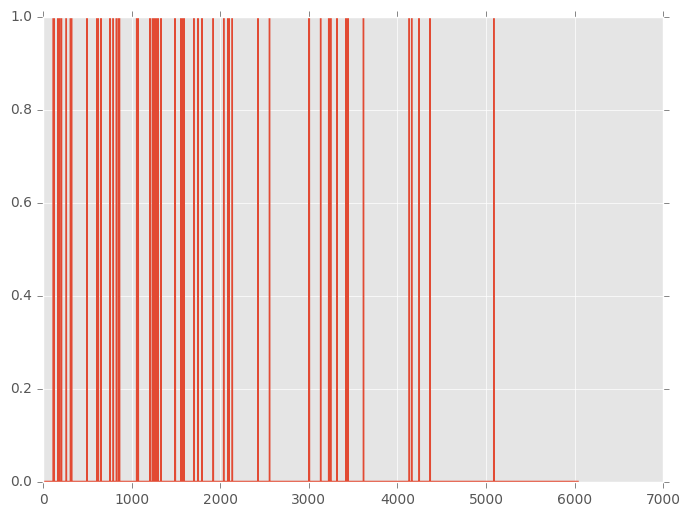

In [18]:
if PLOT: plt.plot(np.mean(np.mean(data_train, axis=2)==0, axis=1))

'Average (LOGT) power by channel'

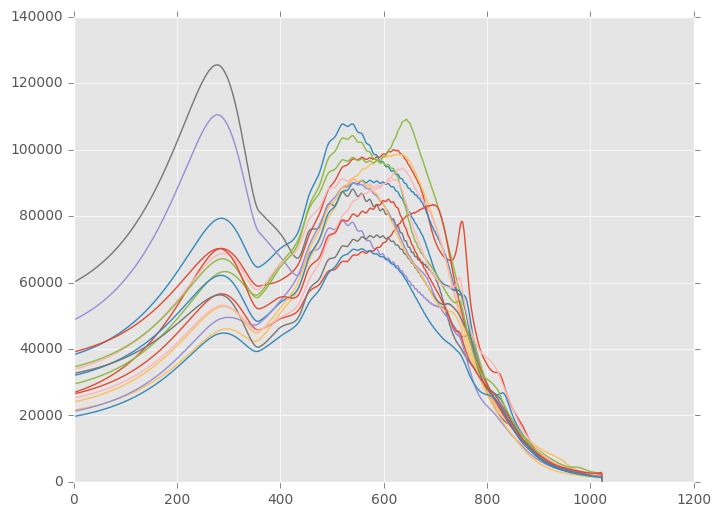

In [19]:
if PLOT: plt.plot(np.mean(data_train, axis=0))
'Average (LOGT) power by channel'

'data set 0 vs 1'

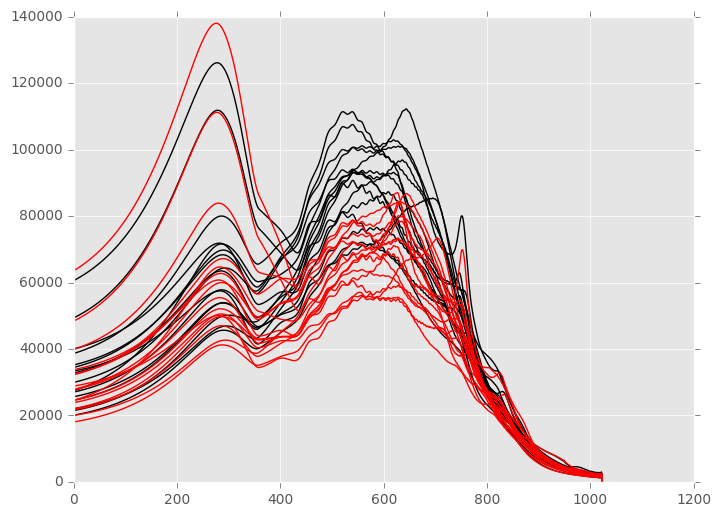

In [20]:
if PLOT: plt.plot(np.sum(d0, axis=0) / n0, c='k')
if PLOT: plt.plot(np.sum(d1, axis=0) / n1, c='r')

'data set 0 vs 1'


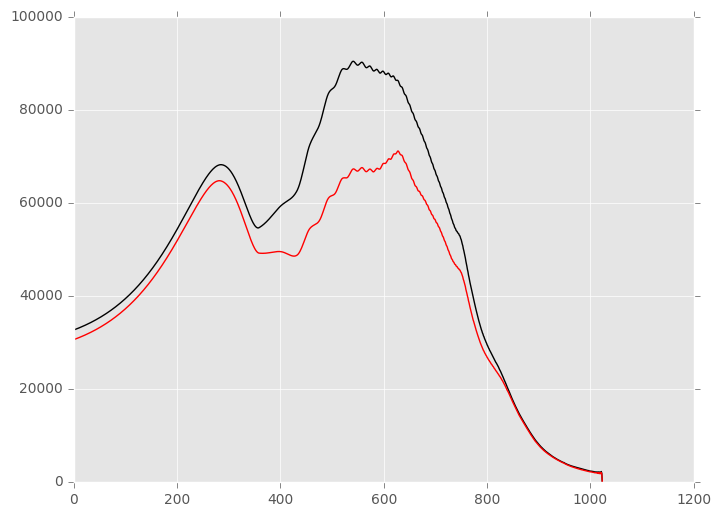

In [21]:
if PLOT: plt.plot(np.mean(np.sum(d0, axis=0) / n0, axis=1), c='k')
if PLOT: plt.plot(np.mean(np.sum(d1, axis=0) / n1, axis=1), c='r')

# NICE!

In [22]:
 # avg along electrodes
# simple_dtrain = np.mean(data_train, axis=2)
# simple_dtest = np.mean(data_test, axis=2)
subdiv = 64
simple_dtrain = data_train[:,::subdiv,:].reshape(-1,1024*16//subdiv)
simple_dtest = data_test[:,::subdiv,:].reshape(-1,1024*16//subdiv)

# Normalize ghetto style
simple_dtrain -= np.mean(simple_dtrain)
simple_dtest -= np.mean(simple_dtest)
simple_dtrain /= np.std(simple_dtrain)
simple_dtest /= np.std(simple_dtest)
print(simple_dtrain.shape, simple_dtest.shape)

(6041, 256) (1908, 256)


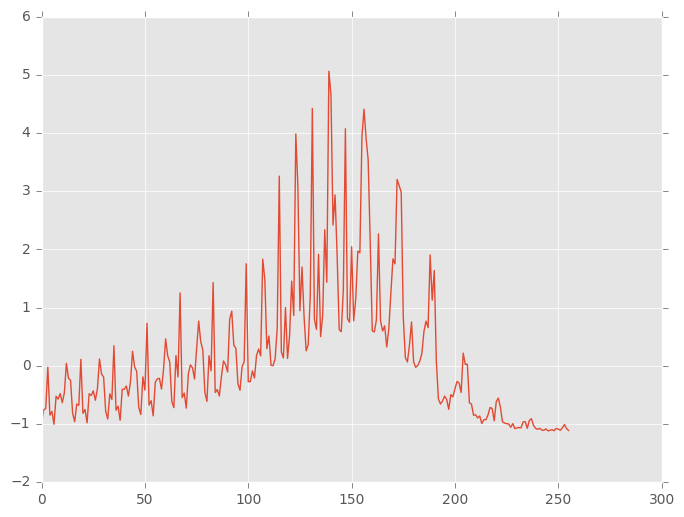

In [23]:
plt.plot(simple_dtrain[3])

In [24]:
y = np.vstack([name_mask, ~name_mask]).T # label vector will be (N, S), N hot for 'no seiz', S hot for 'seize'
print(y.shape)

(6041, 2)


In [25]:
dtrain_set = np.concatenate([simple_dtrain, y], axis=1)
dtrain_set.shape

(6041, 258)

In [26]:
dframe = pd.DataFrame(dtrain_set)

In [27]:
d0 = dframe[dframe.iloc[:,-1] == 0]
d1 = dframe[dframe.iloc[:,-1] == 1]
print(d0.shape, d1.shape)
nfalse, nhit = d0.shape[0], d1.shape[0]

(5592, 258) (449, 258)


In [28]:
offset = np.random.randint(0, nfalse-nhit-1)
d0b = d0[offset:offset+nhit]
print(d0b.shape)

(449, 258)


In [29]:
d0b_ = d0b.as_matrix()
d1_ = d1.as_matrix()

d1_

array([[-0.91700531, -0.28894038, -0.34717156, ..., -1.13051259,
         0.        ,  1.        ],
       [-1.18640367, -0.25012621, -0.20001391, ..., -1.13099762,
         0.        ,  1.        ],
       [-0.89470504, -0.23833191,  0.77783794, ..., -1.12877081,
         0.        ,  1.        ],
       ..., 
       [-3.23013193, -1.15766797, -0.39704927, ..., -1.11376105,
         0.        ,  1.        ],
       [-1.91395593, -0.82024792, -0.15868652, ..., -1.10956531,
         0.        ,  1.        ],
       [-1.00638979, -0.68105726, -1.1176758 , ..., -1.11182738,
         0.        ,  1.        ]])

### Shuffle and shit

In [30]:
subdiv_vec =1
new_set = np.concatenate([d0b_, d1_], axis=0)
print(new_set.shape)
np.random.shuffle(new_set)
print(np.mean(new_set[:nhit,-1]))
simple_dtrain= new_set[:,:-2]
simple_dtrain_lab = new_set[:,-1]
simple_dtrain = simple_dtrain[:,::subdiv_vec]
print(simple_dtrain.shape)
print(np.mean(simple_dtrain_lab[:nhit]))


(898, 258)
0.512249443207
(898, 256)
0.512249443207


In [31]:
simple_dtrain

array([[ 1.09436323, -0.38241623, -0.78181227, ..., -1.07758224,
        -1.06105588, -1.0736218 ],
       [ 1.0318697 ,  0.04686899, -0.72134737, ..., -1.07334895,
        -1.04634778, -1.05859992],
       [-0.2980713 , -0.41275476,  0.12626391, ..., -1.07665512,
        -1.06089031, -1.06547141],
       ..., 
       [ 0.04337007, -0.16303827, -0.76834539, ..., -1.07211251,
        -1.05409656, -1.06555994],
       [ 0.68838182,  0.02950078, -0.6178783 , ..., -1.06445315,
        -1.04195525, -1.0549624 ],
       [ 1.52224935,  0.01721282, -0.66457715, ..., -1.07035278,
        -1.04239151, -1.0617209 ]])

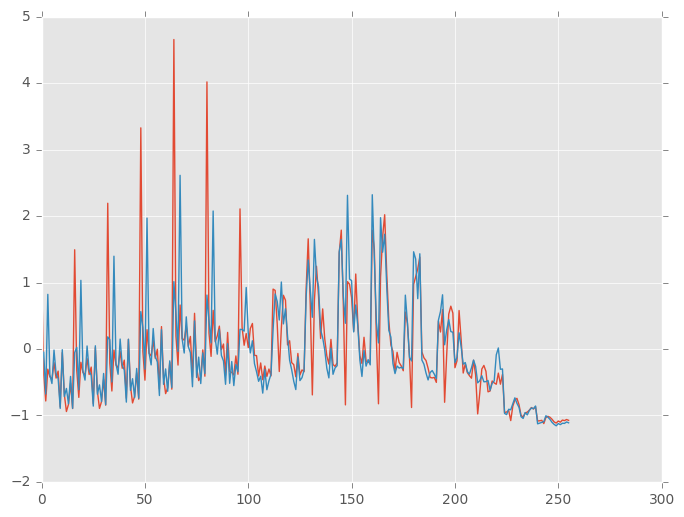

In [32]:
plt.plot(simple_dtrain[0])
plt.plot(simple_dtest[0])

In [33]:
# Parition the data into training and evaluation sets
partition = 3*simple_dtrain.shape[0] // 4
# Build 3 layer DNN with 10, 20, 10 units respectively.
nn0 = simple_dtrain.shape[1]
nn1 = 2* nn0
nn2 = nn0
X=simple_dtrain[:partition]
Y=simple_dtrain_lab[:partition]
Xv=simple_dtrain[partition:]
Yv=simple_dtrain_lab[partition:]


In [34]:
print(Y.shape, np.mean(Y), np.mean(Yv))
print(X.shape, Xv.shape, Y.shape, Yv.shape)

(673,) 0.503714710253 0.488888888889
(673, 256) (225, 256) (673,) (225,)


In [33]:
assert 0 # break point

AssertionError: 

In [ ]:
# Classification
# def do_a_graph():
# with tf.Graph().as_default(): # re-initializing the cells fucks shit up yo
tf.reset_default_graph()
tflearn.init_graph(num_cores=8, gpu_memory_fraction=0.5) # DO ONLY ONCE!

net = tflearn.input_data(shape=[None, nn0])
net = tflearn.fully_connected(net, 10)
# net = tflearn.dropout(net, 0.5)
net = tflearn.fully_connected(net, 1, activation='softmax')
net = tflearn.regression(net, optimizer='adam', loss='categorical_crossentropy')

model = tflearn.DNN(net)
model.fit(X, Y.reshape(-1,1),n_epoch=1)
# model.save('model')
    #     return model

In [ ]:
# with tf.Graph().as_default(): 
#     model.load('model')
ev = model.evaluate(Xv, Yv.reshape(-1,1))
print(ev)

In [ ]:
ev

In [ ]:
pr = model.predict(simple_dtest)

In [ ]:
pr_ = np.array(pr)

In [ ]:
np.mean(pr_[:,0])

In [ ]:
pr_.shape

In [ ]:
guess = pr_[:,1] > .5
guess

In [ ]:
names_test['guess'] = pd.Series(pr_[1,:])

In [ ]:
names_test['']

In [ ]:
perc = lm.Perceptron()

In [ ]:
perc.fit(X, Y)

In [ ]:
perc.score(Xv, Yv)

In [ ]:
pr = perc.predict(simple_dtest[:,::16])
print(pr.mean())

In [ ]:
names_test['guess'] = pd.Series(pr)

In [ ]:
names_test['File'] = [os.path.basename(name) for name in names_test['path']]

In [ ]:
names_test.to_csv('guess11_10_perc.csv')

In [ ]:
ls

# SKLearn MLP

In [37]:
mlp = nn.MLPClassifier(hidden_layer_sizes=(256,32,256,32), activation='relu', warm_start=1)

In [38]:
mlp.fit(X, Y)
mlp.score(Xv, Yv)

0.93777777777777782

In [39]:
pr = mlp.predict(simple_dtest)
print(pr.mean())

0.502620545073


In [201]:
names_test['Class'] = pd.Series(pr)
names_test['File'] = [os.path.basename(name) for name in names_test['path']]

In [202]:
guessfile = names_test[['File', 'Class']]
guessfile.to_csv('guess11_10_mlp_256.csv', index=False)

In [40]:
mlp_z = nn.MLPClassifier(hidden_layer_sizes=(256,32,256,32), activation='relu', warm_start=1)

In [48]:
robuster = preproc.RobustScaler()

In [49]:
robuster.fit(X, Y)

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)

In [52]:
X_r = robuster.fit_transform(X)
Xv_r = robuster.fit_transform(Xv)

In [53]:
mlp.fit(X_r, Y)
mlp.score(Xv_r, Yv)

0.88444444444444448

In [56]:
pred = mlp.predict(Xv)
np.mean(pred, axis=0), np.mean(Yv, axis=0)

(0.34666666666666668, 0.48888888888888887)

# K-Fold MLP

In [109]:
models = [nn.MLPClassifier(hidden_layer_sizes=(256,32,256,32), activation='relu', warm_start=1) for i in range(10)]

In [ ]:
for i in range(10):
    (xt, yt), (xv, yv) = datasets[i]
    models[i].fit(xt, yt)
    print

# Sparse PCA

In [177]:
from sklearn import decomposition

In [206]:
foo = decomposition.SparsePCA(16)

In [207]:
foo.fit(X, Y)

SparsePCA(U_init=None, V_init=None, alpha=1, max_iter=1000, method='lars',
     n_components=16, n_jobs=1, random_state=None, ridge_alpha=0.01,
     tol=1e-08, verbose=False)

In [208]:
foo.components_

array([[ 11.64966909,   4.39139989,  11.08444758, ...,  25.82489159,
         26.19093528,  26.62494138],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       ..., 
       [  0.        ,   0.        ,   0.        , ...,   0.38085367,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,  -4.1738491 ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In [209]:
foo.components_.shape

(16, 256)

In [212]:
xprime = foo.transform(X)

In [213]:
xprime.shape

(673, 16)

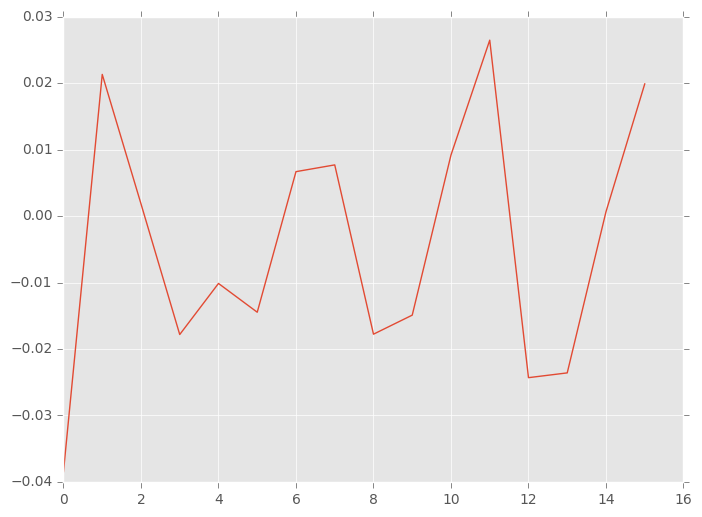

In [214]:
plt.plot(np.mean(xprime, axis=0))

In [229]:
mlp = nn.MLPClassifier(hidden_layer_sizes=(512,16,4), activation='relu', warm_start=1)

In [240]:
mlp.fit(xprime, Y)
print(mlp.score(foo.transform(Xv), Yv))
pr = mlp.predict(foo.transform(simple_dtest))
print(pr.mean())

0.857777777778
0.68501048218


In [241]:
names_test['Class'] = pd.Series(pr)
names_test['File'] = [os.path.basename(name) for name in names_test['path']]

In [242]:
guessfile = names_test[['File', 'Class']]
guessfile.to_csv('guess11_10_mlp_pca16.csv', index=False)